In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import requests
import cv2
from scipy.ndimage import convolve, median_filter, gaussian_filter
from scipy.fft import fft2, fftshift
from skimage.util import random_noise
from sklearn.metrics import mean_squared_error
from PIL import Image
from io import BytesIO
from pprint import pprint
from scipy.ndimage import binary_fill_holes

In [2]:
# Seed Selection Function based on Maximum Intensity
def select_seeds(image, block_size=8, num_seeds=5):
    rows, cols = image.shape[:2]
    max_intensities = []
    block_centers = []

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
            block = image[i:i+block_size, j:j+block_size]
            max_intensity = np.max(block)
            max_intensities.append(max_intensity)
            # block_centers.append((j + block_size // 2, i + block_size // 2))  # Note: (x, y) format
            block_centers.append((i + block_size // 2, j + block_size // 2))  # Note: (x, y) format

    top_blocks = np.argsort(max_intensities)[-num_seeds:]
    seeds = [block_centers[i] for i in top_blocks]

    return seeds

In [3]:
def region_growing_v2(image, seed=None, threshold_factor=0.1):
    """
    Perform region growing algorithm on a grayscale image using histogram and CDF for dynamic thresholding.

    Parameters:
    image (numpy.ndarray): Grayscale image.
    seed (tuple): Starting point (x, y) for region growing. If None, the seed will be chosen automatically.
    threshold_factor (float): Factor to determine dynamic threshold based on intensity range.

    Returns:
    numpy.ndarray: Segmented image.
    """
    # Image dimensions
    rows, cols = image.shape

    # If seed is not specified, select it based on intensity
    if seed is None:
        seed = np.unravel_index(np.argmax(image, axis=None), image.shape)

    # Get the intensity of the seed point
    seed_intensity = image[seed]

    # Determine the dynamic threshold based on the intensity at the seed point
    intensity_range = np.max(image) - np.min(image)
    dynamic_threshold = intensity_range * threshold_factor

    # Initialize segmented output image
    segmented = np.zeros_like(image, dtype=int)

    # List of pixels that need to be examined, starting with the seed point
    pixel_list = [seed]

    # Region growing algorithm
    while pixel_list:
        x, y = pixel_list.pop(0)
        if not segmented[x, y]:
            segmented[x, y] = 255
            # Check the 8-neighbors
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    # Skip the current pixel
                    if dx == 0 and dy == 0:
                        continue
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols:
                        if abs(int(image[nx, ny]) - seed_intensity) < dynamic_threshold:
                            pixel_list.append((nx, ny))
    
    # Function to perform fill holes operation
    def fill_holes(segmented_image):
        # Fill holes using binary fill holes operation
        filled_image = binary_fill_holes(segmented_image).astype(int)
        return filled_image
    
    segmented = fill_holes(segmented)
    segmented = (segmented * 255).astype(np.uint8)

    return segmented, seed

In [4]:
def region_growing_v3(image, seed=None, initial_threshold_factor=0.3, adjustment_factor=0.05):
    """
    Perform region growing algorithm on a grayscale image with dynamic threshold adjustment.

    Parameters:
    image (numpy.ndarray): Grayscale image.
    seed (tuple): Starting point (x, y) for region growing. If None, the seed will be chosen automatically.
    initial_threshold_factor (float): Initial factor to determine dynamic threshold based on intensity range.
    adjustment_factor (float): Factor to adjust the threshold during the growing process.

    Returns:
    numpy.ndarray: Segmented image.
    """
    rows, cols = image.shape
    if seed is None:
        seed = np.unravel_index(np.argmax(image, axis=None), image.shape)

    seed_intensity = image[seed]
    intensity_range = np.max(image) - np.min(image)
    dynamic_threshold = intensity_range * initial_threshold_factor

    segmented = np.zeros_like(image, dtype=bool)
    pixel_list = [seed]

    while pixel_list:
        x, y = pixel_list.pop(0)
        if not segmented[x, y]:
            segmented[x, y] = True
            region_mean = np.mean(image[segmented])
            region_std = np.std(image[segmented])

            # Adjust the dynamic threshold based on the mean and standard deviation of the segmented region
            dynamic_threshold = max(region_std * adjustment_factor, dynamic_threshold)

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols:
                        if abs(int(image[nx, ny]) - region_mean) < dynamic_threshold:
                            pixel_list.append((nx, ny))

    # Function to perform fill holes operation
    def fill_holes(segmented_image):
        # Fill holes using binary fill holes operation
        filled_image = binary_fill_holes(segmented_image).astype(int)
        return filled_image
    
    segmented = fill_holes(segmented)
    segmented = (segmented * 255).astype(np.uint8)
    
    return segmented, seed

In [5]:
def draw_intersection_of_binary_images_v3(image1, image2):
    """
    Draw the intersection of two binary images, where intersection is red, non-intersection is white,
    and background is black.

    Parameters:
    image1, image2 (numpy.ndarray): Two binary images of the same size.

    Returns:
    numpy.ndarray: Image highlighting the intersection in red, non-intersection in white, and background in black.
    """
    if image1.shape != image2.shape:
        raise ValueError("The input images must have the same size")

    # Create an image to display the result
    result_image = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)

    # Intersection (red)
    intersection = (image1 == 255) & (image2 == 255)
    result_image[intersection] = [255, 0, 0]

    # Non-intersecting parts of the images (white)
    non_intersection = ((image1 == 255) | (image2 == 255)) & ~intersection
    result_image[non_intersection] = [255, 255, 255]

    # Background remains black (as initialized)

    return result_image

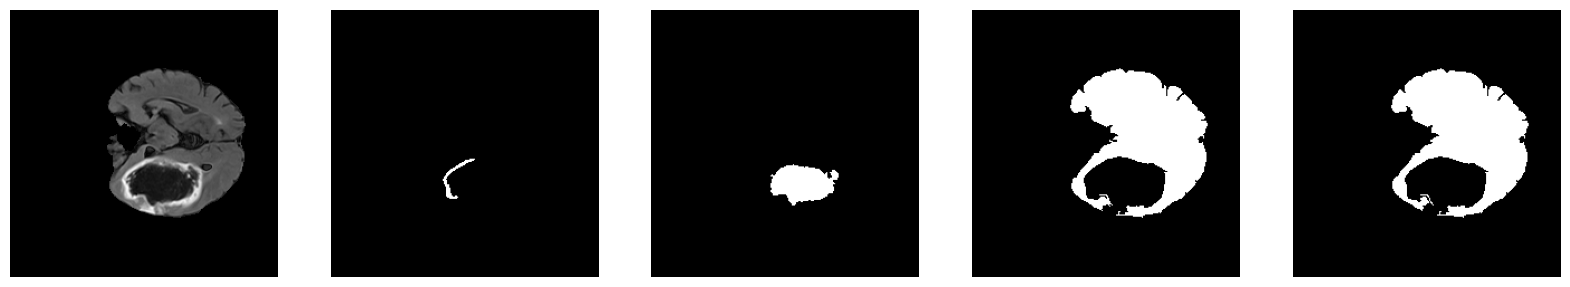

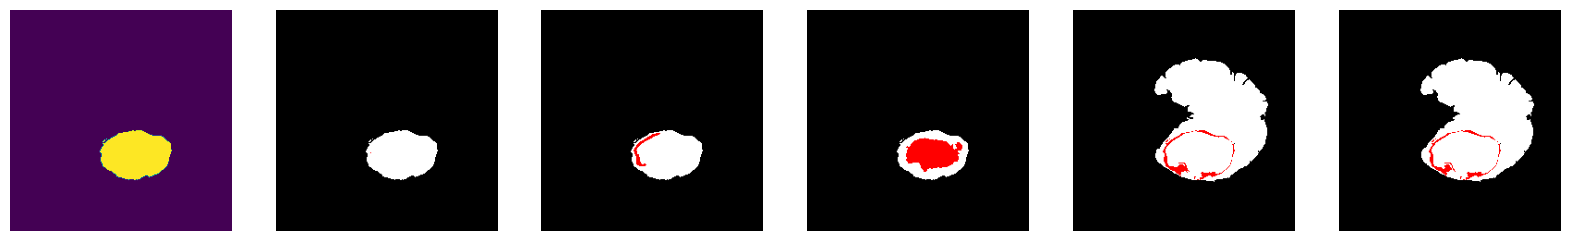

In [9]:
data_folder_path = 'Images/Raw Images/Dataset2/Set1/25'
# flair_path should be the file inside the data_folder_path that contains the word flair and ends with .png
flair_path = os.path.join(data_folder_path, [file for file in os.listdir(data_folder_path) if 'flair' in file and file.endswith('.png')][0])
# gt_path should be the file inside the data_folder_path that contains exactly the word seg and ends with .png
gt_path = os.path.join(data_folder_path, [file for file in os.listdir(data_folder_path) if 'seg.' in file and file.endswith('.png')][0])

flair_image = cv2.imread(flair_path, cv2.IMREAD_GRAYSCALE)
gt_image = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

# Get seeds
seeds = select_seeds(flair_image, block_size=8, num_seeds=3)

# print(seeds)

seeds_img = np.copy(flair_image)
# Visualize seeds on the original image
for x, y in seeds:
    cv2.circle(seeds_img, (y, x), 2, (0, 255, 0), -1)  # Red circles
    
max_intensity_seed = np.unravel_index(np.argmax(flair_image, axis=None), flair_image.shape)
cv2.circle(seeds_img, 
           (max_intensity_seed[1], max_intensity_seed[0]), 
           2, 
           (255, 255, 255), -1)  # Red circles

# # Display the image
# plt.imshow(seeds_img)
# plt.show()


all_results = [flair_image]
segmented, _ = region_growing_v3(flair_image, seed=max_intensity_seed, initial_threshold_factor=0.15, adjustment_factor=0.05)
all_results.append(segmented)

for seed in seeds:
    segmented, _ = region_growing_v3(flair_image, seed=seed, initial_threshold_factor=0.15, adjustment_factor=0.05)
    all_results.append(segmented)
    
# plot all of them side by side
fig, ax = plt.subplots(1, len(all_results), figsize=(20, 20))

for i, result in enumerate(all_results):
    ax[i].imshow(result, cmap='gray')
    ax[i].axis('off')
    
plt.show()


all_intersections = [gt_image]

for i, result in enumerate(all_results):
    intersection = draw_intersection_of_binary_images_v3(gt_image, result)
    all_intersections.append(intersection)
    
# plot all of them side by side
fig, ax = plt.subplots(1, len(all_intersections), figsize=(20, 20))

for i, intersection in enumerate(all_intersections):
    ax[i].imshow(intersection)
    ax[i].axis('off')

plt.show()

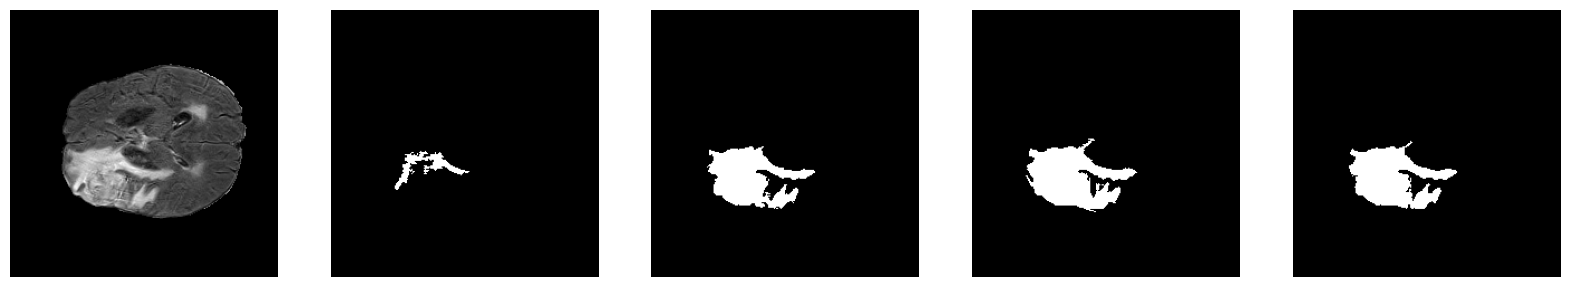

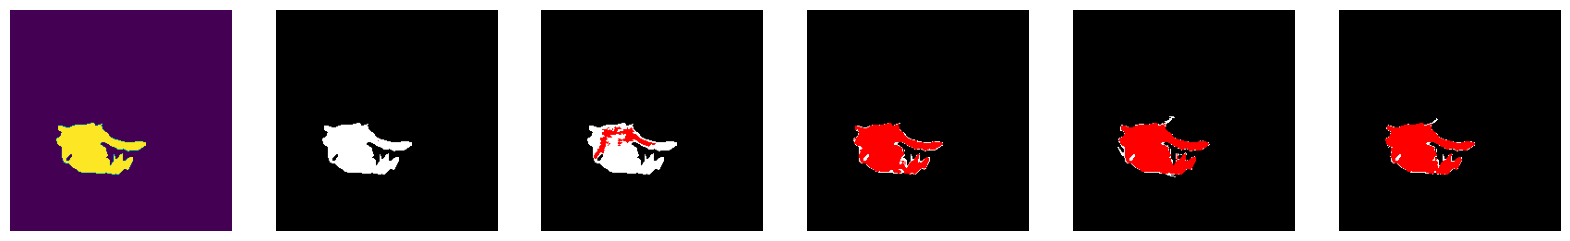

In [44]:
data_folder_path = 'Images/Raw Images/Dataset2/Set2/15'
# flair_path should be the file inside the data_folder_path that contains the word flair and ends with .png
flair_path = os.path.join(data_folder_path, [file for file in os.listdir(data_folder_path) if 'flair' in file and file.endswith('.png')][0])
# gt_path should be the file inside the data_folder_path that contains exactly the word seg and ends with .png
gt_path = os.path.join(data_folder_path, [file for file in os.listdir(data_folder_path) if 'seg.' in file and file.endswith('.png')][0])

flair_image = cv2.imread(flair_path, cv2.IMREAD_GRAYSCALE)
gt_image = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

# Get seeds
seeds = select_seeds(flair_image, block_size=8, num_seeds=3)

# print(seeds)

seeds_img = np.copy(flair_image)
# Visualize seeds on the original image
for x, y in seeds:
    cv2.circle(seeds_img, (y, x), 2, (0, 255, 0), -1)  # Red circles
    
max_intensity_seed = np.unravel_index(np.argmax(flair_image, axis=None), flair_image.shape)
cv2.circle(seeds_img, 
           (max_intensity_seed[1], max_intensity_seed[0]), 
           2, 
           (255, 255, 255), -1)  # Red circles

# # Display the image
# plt.imshow(seeds_img)
# plt.show()


all_results = [flair_image]
segmented, _ = region_growing_v2(flair_image, seed=max_intensity_seed, threshold_factor=0.25)
all_results.append(segmented)

for seed in seeds:
    segmented, _ = region_growing_v2(flair_image, seed=seed, threshold_factor=0.3)
    all_results.append(segmented)
    
# plot all of them side by side
fig, ax = plt.subplots(1, len(all_results), figsize=(20, 20))

for i, result in enumerate(all_results):
    ax[i].imshow(result, cmap='gray')
    ax[i].axis('off')
    
plt.show()


all_intersections = [gt_image]

for i, result in enumerate(all_results):
    intersection = draw_intersection_of_binary_images_v3(gt_image, result)
    all_intersections.append(intersection)
    
# plot all of them side by side
fig, ax = plt.subplots(1, len(all_intersections), figsize=(20, 20))

for i, intersection in enumerate(all_intersections):
    ax[i].imshow(intersection)
    ax[i].axis('off')

plt.show()